In [1]:
!pip install livelossplot --quiet

In [2]:
import torch
from torch import nn as nn
from torchvision.datasets import STL10
from torch.utils.data import DataLoader, Dataset
from torchvision.models import efficientnet_b0, mobilenet_v2
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
from math import floor
from random import sample
import json
from matplotlib import pyplot as plt

# for pgf export of plots
"""import matplotlib
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pgf', FigureCanvasPgf)

matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False
})"""

from livelossplot import PlotLosses

In [3]:
batch_size = 2**7
batch_size

128

In [4]:
dataset = STL10('./dataset', split='train', download=True, folds=0, transform=transforms.ToTensor())
validation_set = STL10('./dataset', split='train', download=True, folds=1, transform=transforms.ToTensor())
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=1000, shuffle=True)
len(dataset)

Files already downloaded and verified
Files already downloaded and verified


1000

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
effnet_b0 = mobilenet_v2(num_classes=10).to(device)  # efficientnet_b0(num_classes=10).to(device)
print(f"Using device: {device} -> {torch.cuda.get_device_name(device) if torch.cuda.is_available() else 'cpu'}")

Using device: cuda -> Tesla T4


## Model training

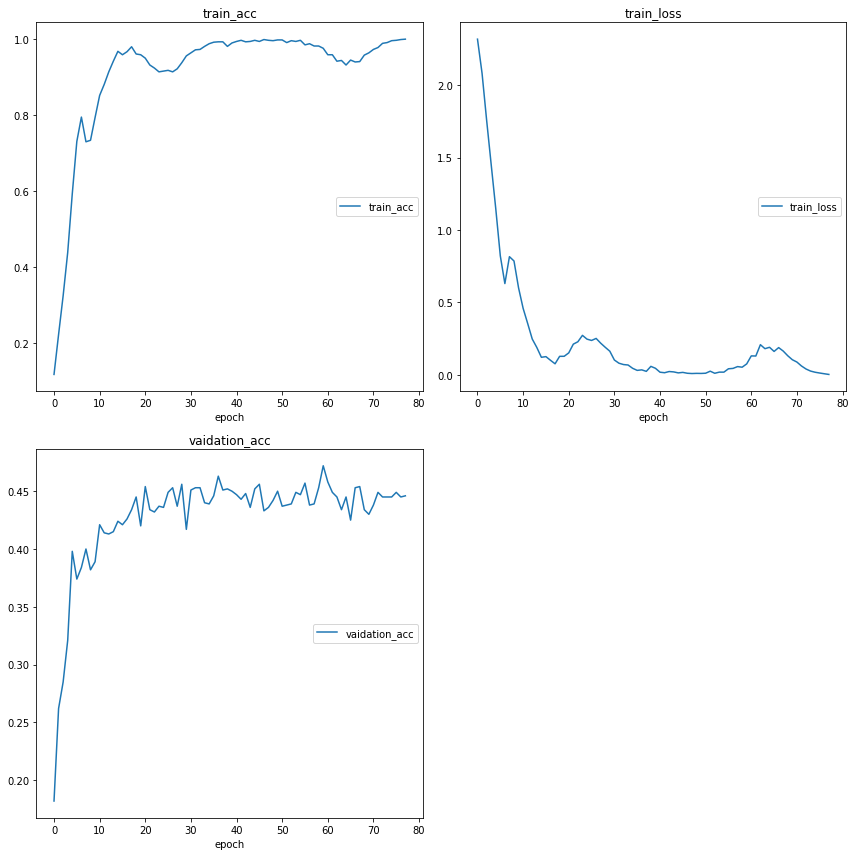

train_acc
	train_acc        	 (min:    0.118, max:    1.000, cur:    1.000)
train_loss
	train_loss       	 (min:    0.003, max:    2.317, cur:    0.003)
vaidation_acc
	vaidation_acc    	 (min:    0.182, max:    0.472, cur:    0.446)


In [6]:
N = 100

optim = torch.optim.Adam(effnet_b0.parameters())

def train(epochs, model, optim, train_loader, validation_loader=None, min_loss=5E-3):
  L = nn.NLLLoss()
  lsm = nn.LogSoftmax(dim=-1)
  lossplot = PlotLosses()
  logs = []
  for _ in range(epochs):
    # training
    running_loss = 0
    corrects = 0
    for x, y in train_loader:
      optim.zero_grad()
      x, y = x.to(device), y.to(device)
      pred = lsm(model(x))
      loss = L(pred, y)
      running_loss += loss.item() * y.shape[0]
      corrects += (pred.argmax(dim=-1) == y).sum(dim=0).item()
      loss.backward()
      optim.step()
    log = {'train_loss': running_loss / len(train_loader.dataset), 'train_acc': corrects / len(train_loader.dataset)}

    #validation
    if validation_loader is not None:
      correct = 0
      for x, y in validation_loader:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
          pred = model(x).argmax(dim=-1)
          correct += (pred == y).sum(dim=0).item()
      log['vaidation_acc'] = correct / len(validation_loader.dataset)
    logs.append(log)

    #plotting
    lossplot.update(log)
    lossplot.send()
    if log['train_loss'] < min_loss:
      break
  return logs

train_data_logs = train(N, effnet_b0, optim, train_loader, validation_loader)

In [7]:
print(json.dumps(train_data_logs))

[{"train_loss": 2.3174493503570557, "train_acc": 0.118, "vaidation_acc": 0.182}, {"train_loss": 2.0820663146972658, "train_acc": 0.223, "vaidation_acc": 0.262}, {"train_loss": 1.7588888530731202, "train_acc": 0.325, "vaidation_acc": 0.285}, {"train_loss": 1.4523353786468507, "train_acc": 0.439, "vaidation_acc": 0.321}, {"train_loss": 1.1485330066680908, "train_acc": 0.593, "vaidation_acc": 0.398}, {"train_loss": 0.8216252460479736, "train_acc": 0.731, "vaidation_acc": 0.374}, {"train_loss": 0.6301937084197998, "train_acc": 0.795, "vaidation_acc": 0.384}, {"train_loss": 0.8159384469985962, "train_acc": 0.73, "vaidation_acc": 0.4}, {"train_loss": 0.786033854007721, "train_acc": 0.734, "vaidation_acc": 0.382}, {"train_loss": 0.6006500306129455, "train_acc": 0.794, "vaidation_acc": 0.389}, {"train_loss": 0.45925213384628294, "train_acc": 0.852, "vaidation_acc": 0.421}, {"train_loss": 0.3544041619300842, "train_acc": 0.881, "vaidation_acc": 0.414}, {"train_loss": 0.2472393285036087, "train_

## Generate soft labels + dataset

In [8]:
unl_set = STL10('./dataset', split='unlabeled', download=True, transform=transforms.ToTensor())
unl_loader = DataLoader(unl_set, batch_size=1000, shuffle=False)

Files already downloaded and verified


In [9]:
class SortedList:
  def __init__(self, max_items):
    self.content = []
    self.max_items = max_items

  def add(self, item, prio):
    if len(self) == 0:
      self.content.append((item, prio))
      return
    idx = 0
    while idx < len(self):
      if self.content[idx][1] <= prio:
        break
      idx += 1
    self.content.insert(idx, (item, prio))
    if len(self) > self.max_items:
      self.content = self.content[:self.max_items]

  def __len__(self):
    return len(self.content)

  def __getitem__(self, idx):
    return self.content[idx][0]

  def get_prio(self, idx):
    return self.content[idx][1]

  def __list__(self):
    return [item for item, prio in self.content]

In [10]:
num_classes = 10
# sort by predicted class, in each class sort by model confidence
class_preds = [SortedList(1000) for _ in range(num_classes)]
for x, _ in tqdm(unl_loader):
  x = x.to(device)
  with torch.no_grad():
    pred = effnet_b0(x).softmax(dim=-1)
  for i in range(x.shape[0]):
    class_preds[int(pred[i].argmax().item())].add(x[i].to('cpu'), pred[i].max().item())

  0%|          | 0/100 [00:00<?, ?it/s]

In [11]:
class STM10Soft(Dataset):
  def __init__(self, pred_classes, N=10000, shuffle=True, num_classes=10):
    super().__init__()

    n = floor(N/num_classes)
    if isinstance(pred_classes, SortedList):
      class_preds = [[] for _ in range(num_classes)]
      min_confidences = [2]*num_classes
      for i, (x, k) in enumerate(pred_classes):
        class_preds[k].append(x)
        if pred_classes.get_prio(i) < min_confidences[k]:
          min_confidences[k] = pred_classes.get_prio(i)
    else:
      class_preds = pred_classes
      min_confidences = [class_examples.get_prio(-1) for class_examples in class_preds]

    self.class_indices = [(i, k) for i in range(num_classes) for k in range(len(class_preds[i]))]
    self.class_preds = class_preds
    if shuffle:
      self.class_indices = sample(self.class_indices, len(self.class_indices))

    print('class distribution')
    s1 = 'class\t'
    s2 = 'size\t'
    s3 = 'rel\t'
    s4 = 'min conf.'
    for i in range(num_classes):
      s1 += f'\t{i}'
      s2 += f'\t{len(class_preds[i])}'
      s3 += f'\t{100*len(class_preds[i])/len(self):.1f}%'
      s4 += f'\t{min_confidences[i]:.3f}'
    print(s1)
    print(s2)
    print(s3)
    print(s4)

  def __len__(self):
    return len(self.class_indices)

  def __getitem__(self, idx):
    i, k = self.class_indices[idx]
    return self.class_preds[i][k], i

softl_set = STM10Soft(class_preds)

class distribution
class		0	1	2	3	4	5	6	7	8	9
size		1000	1000	1000	1000	1000	1000	1000	1000	1000	1000
rel		10.0%	10.0%	10.0%	10.0%	10.0%	10.0%	10.0%	10.0%	10.0%	10.0%
min conf.	1.000	1.000	1.000	1.000	1.000	1.000	1.000	1.000	1.000	1.000


In [12]:
len(softl_set)

10000

In [13]:
semi_superv_model = mobilenet_v2(num_classes=10).to(device)  # efficientnet_b0(num_classes=10).to(device)
soft_train_loader = DataLoader(softl_set, batch_size=batch_size, shuffle=True)
optim = torch.optim.Adam(semi_superv_model.parameters())

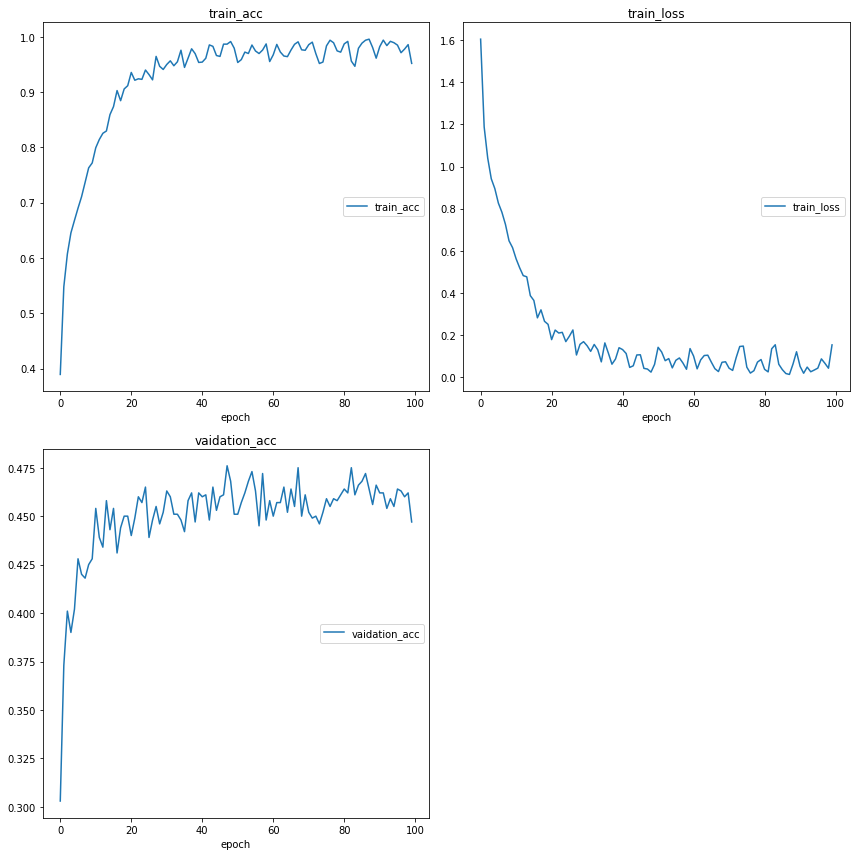

train_acc
	train_acc        	 (min:    0.389, max:    0.996, cur:    0.952)
train_loss
	train_loss       	 (min:    0.013, max:    1.605, cur:    0.154)
vaidation_acc
	vaidation_acc    	 (min:    0.303, max:    0.476, cur:    0.447)


In [14]:
semisupervised_logs = train(100, semi_superv_model, optim, soft_train_loader, validation_loader)

In [15]:
print(json.dumps(semisupervised_logs))

[{"train_loss": 1.604737645149231, "train_acc": 0.3893, "vaidation_acc": 0.303}, {"train_loss": 1.187884111404419, "train_acc": 0.5479, "vaidation_acc": 0.373}, {"train_loss": 1.040198420524597, "train_acc": 0.6072, "vaidation_acc": 0.401}, {"train_loss": 0.9421269014358521, "train_acc": 0.6454, "vaidation_acc": 0.39}, {"train_loss": 0.8954903728485107, "train_acc": 0.668, "vaidation_acc": 0.402}, {"train_loss": 0.8266675485610961, "train_acc": 0.6901, "vaidation_acc": 0.428}, {"train_loss": 0.7829742045402527, "train_acc": 0.7108, "vaidation_acc": 0.42}, {"train_loss": 0.7251754800796508, "train_acc": 0.7368, "vaidation_acc": 0.418}, {"train_loss": 0.6476450298309326, "train_acc": 0.763, "vaidation_acc": 0.425}, {"train_loss": 0.6149071094512939, "train_acc": 0.7719, "vaidation_acc": 0.428}, {"train_loss": 0.5619131937026978, "train_acc": 0.7994, "vaidation_acc": 0.454}, {"train_loss": 0.5194625398635865, "train_acc": 0.8143, "vaidation_acc": 0.439}, {"train_loss": 0.4823592842102051,

In [16]:
test_set = STL10('./dataset', split='test', download=True, transform=transforms.ToTensor())
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

Files already downloaded and verified


In [17]:
def test(model, loader):
  model.eval()
  correct = 0
  for x, y in loader:
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
      pred = model(x).argmax(dim=-1)
    correct += (pred == y).sum(dim=0).item()
  return correct / len(loader.dataset)

In [18]:
print(f"Original model trained on fold0:\tacc={100*test(effnet_b0, test_loader):.2f}%")
print(f"Model trained on soft labeled data:\tacc={100*test(semi_superv_model, test_loader):.2f}%")

Original model trained on fold0:	acc=33.74%
Model trained on soft labeled data:	acc=37.88%


In [19]:
def plot_logs(logs):
  fig, axs = plt.subplots(1, 2)
  fig.subplots_adjust(wspace=.35)
  axs[0].plot(list(range(len(logs))), [log['train_loss'] for log in logs])

  axs[0].set_title('training loss')
  axs[0].set_xlabel('epoch')
  axs[0].set_ylabel('loss')
  axs[1].plot(list(range(len(logs))), [log['train_acc'] for log in logs])
  axs[1].set_title('training accuracy')
  axs[1].set_xlabel('epoch')
  axs[1].set_ylabel('accuracy')
  plt.show()

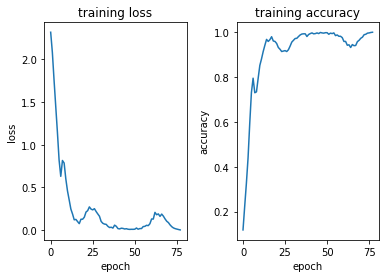

In [20]:
plot_logs(train_data_logs)

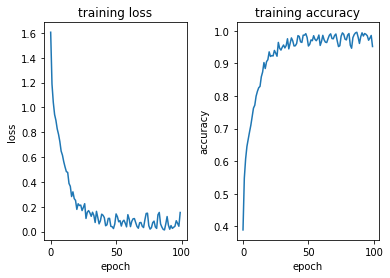

In [21]:
plot_logs(semisupervised_logs)